In [90]:
import pytrec_eval,re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk, imdb
from nameparser.parser import HumanName
from nltk.corpus import wordnet


In [91]:
import warnings
warnings.filterwarnings("ignore")

## Lendo os dados DEV

In [92]:
# # read queries
# queries = pd.read_json('./results/dev_queries.jsonl', lines=True)

# # read the results file
# with open('./results/trec_rerank_dense_my_data_with_cool_corpus.csv', 'r') as f_run:
#     run = pytrec_eval.parse_run(f_run)

# # read qrels
# with open('./results/qrel.txt', 'r') as f_qrel:
#     qrel = pytrec_eval.parse_qrel(f_qrel)

# #evaluate
# evaluator = pytrec_eval.RelevanceEvaluator(
#     qrel, pytrec_eval.supported_measures
# )
# results = evaluator.evaluate(run)

# results['152']['ndcg']

## Lendo os dados TEST

In [130]:
def read_run(queries_filepath: str) -> dict[dict]:
    """
    read eval of my run
    """
    results = {}

    with open(queries_filepath, 'r') as f_run:
        for line in f_run:
            metric, query, score = line.split()
            if re.match(r"\d",score):
                if not query in results:
                    results[query] = {}    
                results[query][metric] = float(score)
    
    return results

In [94]:
queries = pd.read_json('./results/test_queries.jsonl', lines=True)
results = read_run('./results/trec_evals/ufmgDBmBQD.eval')

# Vamos mostrar os resultados retornados pela TREC:

In [131]:
filepaths = ['./results/trec_evals/ufmgDBmBQ.eval', './results/trec_evals/ufmgDBmBQD.eval', './results/trec_evals/ufmgDBmBdTQD.eval', './results/trec_evals/ufmgG4mBQD.eval', './results/trec_evals/ufmgG4dTQD.eval']

mean_run = []
for filepath in filepaths:
    partial_results = read_run(filepath)

    mean_run.append(partial_results['all'])

df = pd.DataFrame(mean_run, index = ['ufmgDBmBQ', 'ufmgDBmBQD', 'ufmgDBmBdTQD', 'ufmgG4mBQD', 'ufmgG4dTQD'])
df[['ndcg', 'recip_rank','recall_1000']]


,ndcg,recip_rank,recall_1000
ufmgDBmBQ,0.2090,0.1636,0.3933
ufmgDBmBQD,0.1998,0.1507,0.4067
ufmgDBmBdTQD,0.1108,0.0505,0.4067
ufmgG4mBQD,0.2404,0.2002,0.3733
ufmgG4dTQD,0.1668,0.1189,0.3733


# Analisar sentence annotations: 

Eles moscam em um monte de coisa, não marcaram a sentença com data como temporal, varias tem plot o que não foi marcado, uma fala que é r rated e nada de falar que tem genre audience

In [96]:
sentences= len(queries.iloc[5]['sentence_annotations'])

for i in range(sentences):
    print(queries.iloc[5]['sentence_annotations'][i]['text'])
    for key, value in queries.iloc[3]['sentence_annotations'][i]['labels']['movie'].items():
        if value:
            print(key, ":", value)
    for key, value in queries.iloc[3]['sentence_annotations'][i]['labels']['context'].items():
        if value:
            print(key, ":", value)
    print("=========================================================")


A cop’s son is very sick and needs a certain type of blood transfusion.
category : True
temporal : True
He finds out an inmate has the same type and once agreed the inmate takes advantage of the situation in the hospital and escapes.
location_type : True
Then a long chasing odyssey till the end when the kid finally gets cured
character : True


# Características das Consultas

Por meio de expressões regulares simples, vamos buscar por elementos comuns nas descrições de filme.


- Eu vou conseguir varias datas, pegar a do IMDB e concatenar com a data normalizada. Eg: Homem aranha é de 2003, vou por a data como 2003 2000
- Verificar classificação indicativa e talvez inferir (???) eu posso pegar um monte de filme do imdb pegar o par (plot-classificação indicativa) e tentar fazer um classificador pra classificação indicativa? 
- Verificar genero e talvez inferir (???) eu posso pegar um monte de filme do imdb pegar o par (plot-genero) e tentar fazer um classificador pro genero? 
- Verificar media (Netflix, streaming, tv...)
- verificar linguagem
- Verificar premios
- Verificar nomes retirar os q forem marcados com comparação??

### Procurando datas nas consultas

In [97]:
def normalize_date(date):
    """
    We have this tendency of using different formats for the same date.
    One of those is using 's for decades, e.g. 80's, 90's, etc.
    This function normalizes the date to the format YYYY.
    """
    
    date = re.sub(r'(s|\')', '', date.lower())
    if len(date) == 2:
        date = '19' + date

    return date

In [122]:
# find dates in all of the queries
queries['date'] = False
queries['normalized_date'] = False

for idx, row in queries.iterrows():
    content = row['title'] + ' ' + row['text']
    match = re.findall(r'(\d{2}\'*`*’*s|\d{4}\'*s*)', content.lower())
    
    if match:
        queries.at[idx, 'date'] = ' '.join(match)
        queries.at[idx, 'normalized_date'] = ' '.join([normalize_date(date) for date in match])

queries.tail(2)

,id,domain,title,text,sentence_annotations,date,normalized_date,parental_rating,genre,media,language,awards,human_names
148,709,movie,"Fantasy movie, kidnapped baby","I saw this movie in the late 80’s, or maybe ev...","[{'id': 1, 'text': 'I saw this movie in the la...",80’s 90’s,80’ 90’,False,fantasy,hbo,False,False,False
149,565,movie,70s film,"Judging by the quality, I’d say this film was ...","[{'id': 1, 'text': 'Judging by the quality, I’...",70s 70s,1970 1970,False,False,False,False,False,False


### Procurando por Classificação Indicativa

In [99]:
def infer_rating(content):
    pass   

In [100]:
# find mentions of parental rating

queries['parental_rating'] = False

for idx, row in queries.iterrows():
    content = row['title'] + ' ' + row['text']
    match = re.findall(r' (pg-13|pg|g rated|r rated)', content.lower())
    
    if match:
        queries.at[idx, 'parental_rating'] = ' '.join(match)
        # queries.at[idx, 'normalized_parental_rating'] = ' '.join(match)

queries.tail(2)

,id,domain,title,text,sentence_annotations,date,normalized_date,parental_rating
148,709,movie,"Fantasy movie, kidnapped baby","I saw this movie in the late 80’s, or maybe ev...","[{'id': 1, 'text': 'I saw this movie in the la...",False,False,False
149,565,movie,70s film,"Judging by the quality, I’d say this film was ...","[{'id': 1, 'text': 'Judging by the quality, I’...",70s,1970,False


### Procurando gênero do filme nas consultas

In [101]:
genres = ['action', 'adventure', 'comedy', 'drama', 'fantasy', 'horror', 'musicals', 'mystery', 'romance', 'science fiction', 'sci-fi', 'sports', 'thriller', 'western']
queries['genre'] = False

# find mentions of genres
for idx, row in queries.iterrows():
    content = row['title'] + ' ' + row['text']
    for genre in genres:
        match = re.findall(r' ' + genre, content.lower())
        if match:
            queries.at[idx, 'genre'] = " ".join(match)

queries.head(4)

,id,domain,title,text,sentence_annotations,date,normalized_date,parental_rating,genre
0,519,movie,redbox mystery driving me insane,"Ok, so my hubby, brother-in-law, and I rented ...","[{'id': 1, 'text': 'Ok, so my hubby, brother-i...",2000,2000,False,mystery
1,1006,movie,"Girl in a red dress enters a bizarre shop, whe...",This was a short movie I saw either on YT or V...,"[{'id': 1, 'text': 'This was a short movie I s...",False,False,False,False
2,477,movie,Guy falls/gets pushed from window. Saved by fl...,One more for today because ya’ll are amazing a...,"[{'id': 1, 'text': 'One more for today because...",False,False,False,comedy
3,528,movie,I can’t remember the name of this movie,"Okay, I watched this movie when I was young, I...","[{'id': 1, 'text': 'Okay, I watched this movie...",False,False,False,False


#3 Procurando pela mídia do filme

In [102]:
media = r' (dvd|netflix|prime video|hbo|streaming|cinema|tv)'
queries['media'] = False

# find mentions of media
for idx, row in queries.iterrows():
    content = row['title'] + ' ' + row['text']
    match = re.findall(media, content.lower())
    if match:
        queries.at[idx, 'media'] = " ".join(match)

queries.head(2)

,id,domain,title,text,sentence_annotations,date,normalized_date,parental_rating,genre,media
0,519,movie,redbox mystery driving me insane,"Ok, so my hubby, brother-in-law, and I rented ...","[{'id': 1, 'text': 'Ok, so my hubby, brother-i...",2000,2000,False,mystery,streaming
1,1006,movie,"Girl in a red dress enters a bizarre shop, whe...",This was a short movie I saw either on YT or V...,"[{'id': 1, 'text': 'This was a short movie I s...",False,False,False,False,False


### Procurando pela lingua original falada no filme

In [103]:
queries['language'] = False

# find mentions of language
for idx, row in queries.iterrows():
    content = row['title'] + ' ' + row['text']
    match = re.findall(r' (english|spanish|french|german|italian|portuguese|japanese|chinese|korean|arabic|dutch|polish|turkish|indonesian|greek|norwegian|swedish|thai|finnish|hebrew|danish|czech|hungarian|vietnamese|romanian|swahili|icelandic|slovak|croatian|serbian|bulgarian|slovenian|lithuanian|latvian|estonian|esperanto)', content.lower())
    if match:
        queries.at[idx, 'language'] = " ".join(match)
    
queries.head(2)

,id,domain,title,text,sentence_annotations,date,normalized_date,parental_rating,genre,media,language
0,519,movie,redbox mystery driving me insane,"Ok, so my hubby, brother-in-law, and I rented ...","[{'id': 1, 'text': 'Ok, so my hubby, brother-i...",2000,2000,False,mystery,streaming,False
1,1006,movie,"Girl in a red dress enters a bizarre shop, whe...",This was a short movie I saw either on YT or V...,"[{'id': 1, 'text': 'This was a short movie I s...",False,False,False,False,False,False


### Procurar por menções de premios e honras

In [104]:
queries['awards'] = False

# find mentions of awards and honors

for idx, row in queries.iterrows():
    content = row['title'] + ' ' + row['text']
    match = re.findall(r' (oscar|academy award|golden globe|bafta|emmy|grammy|tony|independent spirit|cannes|sag|toronto film|tfca|critics choice)', content.lower())
    if match:
        queries.at[idx, 'awards'] = " ".join(match)

queries.head(2)

,id,domain,title,text,sentence_annotations,date,normalized_date,parental_rating,genre,media,language,awards
0,519,movie,redbox mystery driving me insane,"Ok, so my hubby, brother-in-law, and I rented ...","[{'id': 1, 'text': 'Ok, so my hubby, brother-i...",2000,2000,False,mystery,streaming,False,False
1,1006,movie,"Girl in a red dress enters a bizarre shop, whe...",This was a short movie I saw either on YT or V...,"[{'id': 1, 'text': 'This was a short movie I s...",False,False,False,False,False,False,False


### Procurando por nomes de pessoas

In [105]:
def get_human_names(text):
    """
    This function takes a text string and returns a list of tuples of
    human names found in the text
    """
    tokens = nltk.tokenize.word_tokenize(text)
    ia = imdb.IMDb()
    pos = nltk.pos_tag(tokens)
    sentt = nltk.ne_chunk(pos, binary = False)

    candidate = []
    person = []
    name = ""
    for subtree in sentt.subtrees(filter=lambda t: t.label() == 'PERSON' or t.label() == 'ORGANIZATION'):
        
        for leaf in subtree.leaves():
            person.append(leaf[0])
        if len(person) > 1: #avoid grabbing lone surnames
            for part in person:
                name += part + ' '
            if name[:-1] not in candidate:
                ans = ia.search_person(name[:-1])
                if ans and ans[0]['name'].lower() == name[:-1].lower():
                    candidate.append(name[:-1])
                
            name = ''
        person = []

    return candidate



get_human_names("this is a random sample where there will be a Rita Rezende and a Jennifer Lawrence. Mathias Zaracho,  John Smith, also Alright. Drama Movie had blablabla")

['Jennifer Lawrence', 'John Smith']

In [106]:
queries['human_names'] = False

# find mentions of people
for idx, row in queries.iterrows():
    content = row['title'] + ' ' + row['text']
    candidates = get_human_names(content)
    if candidates:
        queries.at[idx, 'human_names'] = " ".join(candidates)

In [107]:
queries.head(10)

,id,domain,title,text,sentence_annotations,date,normalized_date,parental_rating,genre,media,language,awards,human_names
0,519,movie,redbox mystery driving me insane,"Ok, so my hubby, brother-in-law, and I rented ...","[{'id': 1, 'text': 'Ok, so my hubby, brother-i...",2000,2000,False,mystery,streaming,False,False,False
1,1006,movie,"Girl in a red dress enters a bizarre shop, whe...",This was a short movie I saw either on YT or V...,"[{'id': 1, 'text': 'This was a short movie I s...",False,False,False,False,False,False,False,False
2,477,movie,Guy falls/gets pushed from window. Saved by fl...,One more for today because ya’ll are amazing a...,"[{'id': 1, 'text': 'One more for today because...",False,False,False,comedy,False,False,False,False
3,528,movie,I can’t remember the name of this movie,"Okay, I watched this movie when I was young, I...","[{'id': 1, 'text': 'Okay, I watched this movie...",False,False,False,False,tv,english,False,False
4,662,movie,80’s Movie/Show with Mean Girls,I watched this when I was under 10 yrs old and...,"[{'id': 1, 'text': 'I watched this when I was ...",False,False,False,False,False,english,False,False
5,610,movie,Cop’s son needs blood transfusion from an inmate,A cop’s son is very sick and needs a certain t...,"[{'id': 1, 'text': 'A cop’s son is very sick a...",False,False,False,False,False,False,False,False
6,120,movie,"Mental handicaped man, lonely, finds talent pl...",I would very much appreciate if someone coul...,"[{'id': 1, 'text': 'I would very much apprecia...",1980,1980,False,False,False,german,False,False
7,852,movie,Cheque,"I saw it probably after 2005, probably came ou...","[{'id': 1, 'text': 'I saw it probably after 20...",2005,2005,False,False,False,False,False,False
8,965,movie,Man loses his artificial girlfriend and and go...,"the movie looks like made in the 80s , the set...","[{'id': 1, 'text': 'the movie looks like made ...",80s,1980,False,False,tv dvd,english,False,Meg Ryan
9,505,movie,(Warning: Violent gore content ! ) Scene from ...,Two guys meet with some maffia or a gang in a ...,"[{'id': 1, 'text': 'Two guys meet with some ma...",False,False,False,False,False,False,False,False


## Analisando a presença dessas características

In [108]:
feature_presence = [    
    {
        'date': len(queries[queries['date'] != False]),
        'parental_rating': len(queries[queries['parental_rating'] != False]),
        'genre': len(queries[queries['genre'] != False]),
        'media': len(queries[queries['media'] != False]),
        'language': len(queries[queries['language'] != False]),
        'awards': len(queries[queries['awards'] != False]),
        'human_names': len(queries[queries['human_names'] != False]),

    },
    {
        'date': len(queries[queries['date'] != False]) / len(queries),
        'parental_rating': len(queries[queries['parental_rating'] != False]) / len(queries),
        'genre': len(queries[queries['genre'] != False]) / len(queries),
        'media': len(queries[queries['media'] != False]) / len(queries),
        'language': len(queries[queries['language'] != False]) / len(queries),
        'awards': len(queries[queries['awards'] != False]) / len(queries),
        'human_names': len(queries[queries['human_names'] != False]) / len(queries)
    }
]

# lets create a df with the results
feature_presence_df = pd.DataFrame(feature_presence, index=['absolute', 'relative'])
feature_presence_df

,date,parental_rating,genre,media,language,awards,human_names
absolute,74.000000,0.0,45.0,46.000000,47.000000,0.0,13.000000
relative,0.493333,0.0,0.3,0.306667,0.313333,0.0,0.086667


# Breakdown Analysis para as Características achadas

## Distribuição dos scores para as consultas

In [109]:


for entry in results.values():
    if not 'recip_rank' in entry:
        print(entry)
    


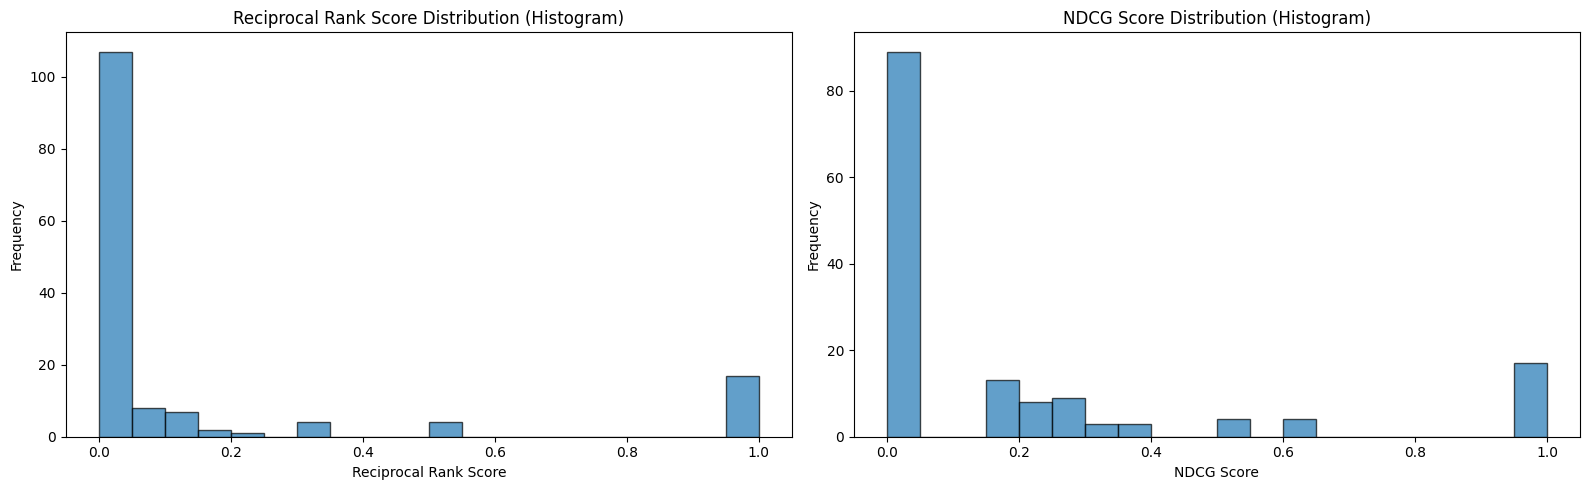

In [136]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))


#get rr scores
rr_scores = [entry['recip_rank'] for entry in results.values()]

#get ndcg scores
ndcg_scores = [entry['ndcg'] for entry in results.values()]

# Create a histogram plot
axes[0].hist(rr_scores, bins=20, edgecolor='k', alpha=0.7)
axes[0].set_xlabel('Reciprocal Rank Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Reciprocal Rank Score Distribution (Histogram)')

# Create a histogram plot
axes[1].hist(ndcg_scores, bins=20, edgecolor='k', alpha=0.7)
axes[1].set_xlabel('NDCG Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('NDCG Score Distribution (Histogram)')

plt.tight_layout()
plt.show()


## Divisão dos grupos, criaremos 4 grupos para ndcg:
- ndcg == 0
- ndcg > 0 e ndcg <= 0.247
- ndcg > 0.247 e ndcg < 1
- ndcg == 1

OBS: 0.247 não é um numero arbitrario é o NDCG do melhor baseline.

### Gerando o grupo de consultas cujo NDCG é igual a 0.0

In [111]:
# lets take a look at the queries who got ndcg = 0

# get the queries with ndcg = 0
ndcg_0 = [int(k) for k, v in results.items() if v['ndcg'] == 0]

# get the queries text with ndcg = 0
queries[queries['id'].isin(ndcg_0)][['id','title', 'text', 'date', 'parental_rating','genre', 'media', 'language', 'awards', 'human_names']].head(10)

,id,title,text,date,parental_rating,genre,media,language,awards,human_names
0,519,redbox mystery driving me insane,"Ok, so my hubby, brother-in-law, and I rented ...",2000,False,mystery,streaming,False,False,False
1,1006,"Girl in a red dress enters a bizarre shop, whe...",This was a short movie I saw either on YT or V...,False,False,False,False,False,False,False
3,528,I can’t remember the name of this movie,"Okay, I watched this movie when I was young, I...",False,False,False,tv,english,False,False
4,662,80’s Movie/Show with Mean Girls,I watched this when I was under 10 yrs old and...,False,False,False,False,english,False,False
6,120,"Mental handicaped man, lonely, finds talent pl...",I would very much appreciate if someone coul...,1980,False,False,False,german,False,False
9,505,(Warning: Violent gore content ! ) Scene from ...,Two guys meet with some maffia or a gang in a ...,False,False,False,False,False,False,False
12,869,Amovie where everything is controlled by a guy...,So its from the 90s or early 2000s. its like a...,90s 2000s,False,False,False,False,False,False
13,632,Little girl killed at the end,I saw this movie in 2014 (I think) on a cable ...,2014,False,fantasy,False,False,False,False
14,945,Comedy movie,I think the movie is from the 80s or early 90s...,80s 90s,False,False,False,False,False,False
16,361,"Bizarre Asian American scifi indie film 90s, s...","It was the mid 90s, shown on a PBS channel. It...",90s 90s,False,False,False,False,False,False


In [112]:
# existem queries q se sairam mal que tem classificação indicativa, genero e descrição do poster!

def get_query_and_link(id = 1):

    print(queries[queries['id'].isin(ndcg_0)][['title']].iloc[id].values[0])
    print(queries[queries['id'].isin(ndcg_0)][['text']].iloc[id].values[0])
    print(queries[queries['id'].isin(ndcg_0)]['wikipedia_url'].iloc[id])
    print("---------------------------------------------------")

### Gerando o grupo de consultas cujo NDCG é menor que 0.2407

In [113]:
# lets take a look at the queries who got ndcg < 0.2407

# get the queries with ndcg < 0.2407
bad_ndcg = [int(k) for k, v in results.items() if v['ndcg'] < 0.2407 and v['ndcg'] > 0]

# get the queries text with ndcg < 0.2407
queries[queries['id'].isin(bad_ndcg)][['id','title', 'text', 'date', 'parental_rating','genre', 'media', 'language', 'awards', 'human_names']].head(10)

,id,title,text,date,parental_rating,genre,media,language,awards,human_names
8,965,Man loses his artificial girlfriend and and go...,"the movie looks like made in the 80s , the set...",80s,False,False,tv dvd,english,False,Meg Ryan
10,783,"LA, teenagers turning into lizards, teenage co...","5-4 years ago I watched loads of weird, mindfu...",False,False,action,False,False,False,False
26,407,Horror movie where the monsters lived in van…,"I think I saw it back in the 80’s, this horror...",False,False,horror,False,False,False,False
28,349,70’s Horror film (Not Poltergeist),All I can recall is a large weird gnarled tree...,False,False,horror,tv,False,False,False
40,261,possibly 70’s movie scene: kid trapped under w...,I was a young kid so this had to be late 80’s ...,70s,False,False,False,english,False,False
48,1031,Italian gangster film?,I remember a movie with a Miles Davis song in ...,False,False,False,False,italian,False,Miles Davis
58,200,Hope you guys can identifiy that movie,I know for sure that movie was filmed before 2...,2013 2008 2012,False,False,dvd,False,False,False
67,970,Horror Movie,About 2 months ago I saw a horror movie about ...,2009,False,horror horror,False,english,False,False
71,558,18th century period piece,At some point the the 90’s I saw a film on tv ...,1700,False,False,tv hbo,False,False,False
73,390,Mind reading woman and cop,What is the name of recent film or TV series p...,False,False,False,tv,False,False,False


### Gerando o grupo de consultas cujo NDCG é maior ou igual a 0.247 e menor que 1.0

In [114]:
# lets take a look at the queries who got ndcg > 0.2

# get the queries with ndcg = 0
good_ndcg = [int(k) for k, v in results.items() if v['ndcg'] >= 0.247 and v['ndcg'] < 1]

# get the queries text with ndcg = 0
queries[queries['id'].isin(good_ndcg)][['id','title', 'text', 'date', 'parental_rating','genre', 'media', 'language', 'awards', 'human_names']].head(10)

,id,title,text,date,parental_rating,genre,media,language,awards,human_names
2,477,Guy falls/gets pushed from window. Saved by fl...,One more for today because ya’ll are amazing a...,False,False,comedy,False,False,False,False
5,610,Cop’s son needs blood transfusion from an inmate,A cop’s son is very sick and needs a certain t...,False,False,False,False,False,False,False
7,852,Cheque,"I saw it probably after 2005, probably came ou...",2005,False,False,False,False,False,False
11,960,"Netflix movie that got removed, probably early...",So about 2-4 years ago I watched a drama movie...,2000,False,drama,netflix,False,False,False
21,884,90s horror movie?????,I think I saw this movie in the late 90s maybe...,90s 2000s 90s 80s,False,horror,False,False,False,False
33,369,a war movie,One of its posters shows a man waving a sheet ...,False,False,False,dvd,english,False,False
53,339,80’s horror movie,I got another one for you guys…this one comes ...,False,False,horror,False,english,False,False
54,302,TV Movie Ghost Story,I turned on the TV one night and found this ge...,False,False,mystery,tv,False,False,False
57,1049,australian school children,I saw this movie in the early 90’s on tv. I t...,False,False,adventure,tv,False,False,False
59,572,can’t find this film – horror/thriller/mystert,"So, there’s this movie. I’ve seen it around 20...",2006,False,horror,False,english,False,False


### Gerando o grupo de consultas cujo NDCG é igual 1.0

In [115]:
# lets take a look at the queries who got ndcg == 1

# get the queries with ndcg = 0
great_ndcg = [int(k) for k, v in results.items() if v['ndcg'] == 1]

# get the queries text with ndcg = 0
queries[queries['id'].isin(great_ndcg)][['id','title', 'text', 'date', 'parental_rating','genre', 'media', 'language', 'awards', 'human_names']].head(10)

,id,title,text,date,parental_rating,genre,media,language,awards,human_names
15,743,1960 style black and white sci-fi short series...,I saw this approximately 2010-2012. Main chara...,2000 2010 1960 2000,False,sci-fi sci-fi,False,english,False,False
18,668,Anyone remember this stalker thriller?,This was a stalker thriller from the 80’s or p...,False,False,thriller thriller,False,False,False,False
19,872,Horror/Slasher Babysitter movie help,"Okay, this one is going to be packed with rand...",False,False,False,False,english,False,False
23,820,Japanese Crime/Horror Movie,A few years ago I happened upon a Japanese mov...,False,False,False,False,japanese japanese,False,False
31,277,Movie about a killer,"So, I saw this movie in the early to mid 2000’...",2000,False,horror,dvd,False,False,False
43,366,Movie where kids wish their mom would disappear?,The movie goes through them having all of thes...,False,False,False,tv,english,False,False
47,745,Help Emergency!,It was this movie I rented from Blockbuster lo...,False,False,False,dvd,False,False,False
61,630,Pirate cartoon,Way back when i saw a cartoon movie of three b...,False,False,False,False,False,False,False
68,618,Chinese Historical Gay Film,It’s a rather strange movie description so bea...,False,False,drama,False,english chinese,False,False
76,518,American Kids Movie,I remember that this movie was in english and ...,2000,False,False,tv,english,False,False


In [128]:
# existem queries q se sairam mal que tem classificação indicativa, genero e descrição do poster!

def get_query_and_link(id = 1):

    print(queries[queries['id'].isin(great_ndcg)][['title']].iloc[id].values[0])
    print(queries[queries['id'].isin(great_ndcg)][['text']].iloc[id].values[0])
    # print(queries[queries['id'].isin(great_ndcg)]['wikipedia_url'].iloc[id])
    print("---------------------------------------------------")

for i in range(10):
    get_query_and_link(i)

1960 style black and white sci-fi short series, made in 2000’s? on ComCast On Demand
I saw this approximately 2010-2012. Main character in a office building when aliens made of light attack. Style of the short series was 1960’s retro black in white but done in 2000’s. A NASA Orion era astronaut comes to the rescue, sent by I think a moon base? (not sure on that) who he has intermittent contact with. NASA astronaut comes with his gun full of bullets, apparently made of light only thing able to kill the light aliens. They have a adventure and at the end they disarm some bomb in a parking garage. Eventually they split paths. NASA is shown on Mercury? in conflict with someone else. While the man in the office gets a package with a bunch of the light bullets. This was in English. On a ComCast on Demand channel, somewhere in some independent? sci-fi channel.
---------------------------------------------------
Anyone remember this stalker thriller?
This was a stalker thriller from the 80’s or

### Porcentagem e quantidade de elementos descritivos de consultas para cada um dos 3 grupos.

In [116]:
size = [
    {
        'size': len(queries),
        'date': len(queries[queries['date'] != False]),
        'parental_rating': len(queries[queries['parental_rating'] != False]),
        'genre': len(queries[queries['genre'] != False]),
        'media': len(queries[queries['media'] != False]),
        'language': len(queries[queries['language'] != False]),
        'awards': len(queries[queries['awards'] != False]),
        'human_names': len(queries[queries['human_names'] != False]),
    },
    {
        'size': len(ndcg_0),
        'date': len(queries[queries['id'].isin(ndcg_0)][queries['date'] != False]),
        'parental_rating': len(queries[queries['id'].isin(ndcg_0)][queries['parental_rating'] != False]),
        'genre': len(queries[queries['id'].isin(ndcg_0)][queries['genre'] != False]),
        'media': len(queries[queries['id'].isin(ndcg_0)][queries['media'] != False]),
        'language': len(queries[queries['id'].isin(ndcg_0)][queries['language'] != False]),
        'awards': len(queries[queries['id'].isin(ndcg_0)][queries['awards'] != False]),
        'human_names': len(queries[queries['id'].isin(ndcg_0)][queries['human_names'] != False]),
    },
    {
        'size': len(bad_ndcg),
        'date': len(queries[queries['id'].isin(bad_ndcg)][queries['date'] != False]),
        'parental_rating': len(queries[queries['id'].isin(bad_ndcg)][queries['parental_rating'] != False]),
        'genre': len(queries[queries['id'].isin(bad_ndcg)][queries['genre'] != False]),
        'media': len(queries[queries['id'].isin(bad_ndcg)][queries['media'] != False]),
        'language': len(queries[queries['id'].isin(bad_ndcg)][queries['language'] != False]),
        'awards': len(queries[queries['id'].isin(bad_ndcg)][queries['awards'] != False]),
        'human_names': len(queries[queries['id'].isin(bad_ndcg)][queries['human_names'] != False]),
    },
    {
        'size': len(good_ndcg),
        'date': len(queries[queries['id'].isin(good_ndcg)][queries['date'] != False]),
        'parental_rating': len(queries[queries['id'].isin(good_ndcg)][queries['parental_rating'] != False]),
        'genre': len(queries[queries['id'].isin(good_ndcg)][queries['genre'] != False]),
        'media': len(queries[queries['id'].isin(good_ndcg)][queries['media'] != False]),
        'language': len(queries[queries['id'].isin(good_ndcg)][queries['language'] != False]),
        'awards': len(queries[queries['id'].isin(good_ndcg)][queries['awards'] != False]),
        'human_names': len(queries[queries['id'].isin(good_ndcg)][queries['human_names'] != False]),
    },
    
    {
        'size': len(great_ndcg),
        'date': len(queries[queries['id'].isin(great_ndcg)][queries['date'] != False]),
        'parental_rating': len(queries[queries['id'].isin(great_ndcg)][queries['parental_rating'] != False]),
        'genre': len(queries[queries['id'].isin(great_ndcg)][queries['genre'] != False]),
        'media': len(queries[queries['id'].isin(great_ndcg)][queries['media'] != False]),
        'language': len(queries[queries['id'].isin(great_ndcg)][queries['language'] != False]),
        'awards': len(queries[queries['id'].isin(great_ndcg)][queries['awards'] != False]),
        'human_names': len(queries[queries['id'].isin(great_ndcg)][queries['human_names'] != False]),
    }
]

# lets make a df with the data
df = pd.DataFrame(size, index=['all','ndcg == 0', 'ndcg < 0.247', '0.247 <= ndcg < 1', 'ndcg == 1'])
df

,size,date,parental_rating,genre,media,language,awards,human_names
all,150,74,0,45,46,47,0,13
ndcg == 0,89,53,0,22,25,28,0,9
ndcg < 0.247,20,9,0,8,10,8,0,2
0.247 <= ndcg < 1,23,8,0,9,6,4,0,2
ndcg == 1,17,4,0,6,5,6,0,0


In [117]:
percentages = [
    {
        'size': len(ndcg_0),
        'date': len(queries[queries['id'].isin(ndcg_0)][queries['date'] != False]) / len(queries[queries['id'].isin(ndcg_0)]),
        'parental_rating': len(queries[queries['id'].isin(ndcg_0)][queries['parental_rating'] != False]) / len(queries[queries['id'].isin(ndcg_0)]),
        'genre': len(queries[queries['id'].isin(ndcg_0)][queries['genre'] != False]) / len(queries[queries['id'].isin(ndcg_0)]),
        'media': len(queries[queries['id'].isin(ndcg_0)][queries['media'] != False]) / len(queries[queries['id'].isin(ndcg_0)]),
        'language': len(queries[queries['id'].isin(ndcg_0)][queries['language'] != False]) / len(queries[queries['id'].isin(ndcg_0)]),
        'awards': len(queries[queries['id'].isin(ndcg_0)][queries['awards'] != False]) / len(queries[queries['id'].isin(ndcg_0)]),
        'human_names': len(queries[queries['id'].isin(ndcg_0)][queries['human_names'] != False]) / len(queries[queries['id'].isin(ndcg_0)]),

    },
    {
        'size': len(bad_ndcg),
        'date': len(queries[queries['id'].isin(bad_ndcg)][queries['date'] != False]) / len(queries[queries['id'].isin(bad_ndcg)]),
        'parental_rating': len(queries[queries['id'].isin(bad_ndcg)][queries['parental_rating'] != False]) / len(queries[queries['id'].isin(bad_ndcg)]),
        'genre': len(queries[queries['id'].isin(bad_ndcg)][queries['genre'] != False]) / len(queries[queries['id'].isin(bad_ndcg)]),
        'media': len(queries[queries['id'].isin(bad_ndcg)][queries['media'] != False]) / len(queries[queries['id'].isin(bad_ndcg)]),
        'language': len(queries[queries['id'].isin(bad_ndcg)][queries['language'] != False]) / len(queries[queries['id'].isin(bad_ndcg)]),
        'awards': len(queries[queries['id'].isin(bad_ndcg)][queries['awards'] != False]) / len(queries[queries['id'].isin(bad_ndcg)]),
        'human_names': len(queries[queries['id'].isin(bad_ndcg)][queries['human_names'] != False]) / len(queries[queries['id'].isin(bad_ndcg)]),
    },
    {
        'size': len(good_ndcg),
        'date': len(queries[queries['id'].isin(good_ndcg)][queries['date'] != False]) / len(queries[queries['id'].isin(good_ndcg)]),
        'parental_rating': len(queries[queries['id'].isin(good_ndcg)][queries['parental_rating'] != False]) / len(queries[queries['id'].isin(good_ndcg)]),
        'genre': len(queries[queries['id'].isin(good_ndcg)][queries['genre'] != False]) / len(queries[queries['id'].isin(good_ndcg)]),
        'media': len(queries[queries['id'].isin(good_ndcg)][queries['media'] != False])  / len(queries[queries['id'].isin(good_ndcg)]),
        'language': len(queries[queries['id'].isin(good_ndcg)][queries['language'] != False]) / len(queries[queries['id'].isin(good_ndcg)]),
        'awards': len(queries[queries['id'].isin(good_ndcg)][queries['awards'] != False]) / len(queries[queries['id'].isin(good_ndcg)]),
        'human_names': len(queries[queries['id'].isin(good_ndcg)][queries['human_names'] != False]) / len(queries[queries['id'].isin(good_ndcg)]),
        
    },
    {
        'size': len(great_ndcg),
        'date': len(queries[queries['id'].isin(great_ndcg)][queries['date'] != False]) / len(queries[queries['id'].isin(great_ndcg)]),
        'parental_rating': len(queries[queries['id'].isin(great_ndcg)][queries['parental_rating'] != False]) / len(queries[queries['id'].isin(great_ndcg)]),
        'genre': len(queries[queries['id'].isin(great_ndcg)][queries['genre'] != False]) / len(queries[queries['id'].isin(great_ndcg)]),
        'media': len(queries[queries['id'].isin(great_ndcg)][queries['media'] != False]) / len(queries[queries['id'].isin(great_ndcg)]),
        'language': len(queries[queries['id'].isin(great_ndcg)][queries['language'] != False]) / len(queries[queries['id'].isin(great_ndcg)]),
        'awards': len(queries[queries['id'].isin(great_ndcg)][queries['awards'] != False]) / len(queries[queries['id'].isin(great_ndcg)]),
        'human_names': len(queries[queries['id'].isin(great_ndcg)][queries['human_names'] != False]) / len(queries[queries['id'].isin(great_ndcg)]),
    }
]

# lets make a df with the data
df = pd.DataFrame(percentages, index=['ndcg == 0', 'ndcg < 0.247', '0.247 <= ndcg < 1', 'ndcg == 1'])
df

,size,date,parental_rating,genre,media,language,awards,human_names
ndcg == 0,89,0.595506,0.0,0.247191,0.280899,0.314607,0.0,0.101124
ndcg < 0.247,20,0.450000,0.0,0.400000,0.500000,0.400000,0.0,0.100000
0.247 <= ndcg < 1,23,0.347826,0.0,0.391304,0.260870,0.173913,0.0,0.086957
ndcg == 1,17,0.235294,0.0,0.352941,0.294118,0.352941,0.0,0.000000


## Qual a quantidade de consultas que se sai muito mal, mal, bem e ótimo para cada uma das características?

In [118]:
# for queries which have date what are the percentages of ndcg = 0, ndcg < 0.247, 0.247 <= ndcg < 1, ndcg == 1
# i want all queries which date is not false and the queries are in ndcg_0

print(f"{len(queries[queries['id'].isin(ndcg_0)][queries['date'] != False])/len(queries[queries['date'] != False])}% das consultas com data tem ndcg = 0")
print(f"{len(queries[queries['id'].isin(bad_ndcg)][queries['date'] != False])/len(queries[queries['date'] != False])}% das consultas com data tem 0 < ndcg < 0.247")
print(f"{len(queries[queries['id'].isin(good_ndcg)][queries['date'] != False])/len(queries[queries['date'] != False])}% das consultas com data tem 0.247 <= ndcg < 1")
print(f"{len(queries[queries['id'].isin(great_ndcg)][queries['date'] != False])/len(queries[queries['date'] != False])}% das consultas com data tem ndcg = 1")


# for queries which have parental_rating what are the percentages of ndcg = 0, ndcg < 0.247, 0.247 <= ndcg < 1, ndcg == 1

0.7162162162162162% das consultas com data tem ndcg = 0
0.12162162162162163% das consultas com data tem 0 < ndcg < 0.247
0.10810810810810811% das consultas com data tem 0.247 <= ndcg < 1
0.05405405405405406% das consultas com data tem ndcg = 1


## proporção de consultas com cada feature entre os 4 grupos:

Agora fazermos (#consultas t.q. date != False e ndcg = 0) / (#consultas t.q date != False)

In [124]:
percentages = [
    {
        'date': len(queries[queries['id'].isin(ndcg_0)][queries['date'] != False])/len(queries[queries['date'] != False]),
        # 'parental_rating': len(queries[queries['id'].isin(ndcg_0)][queries['parental_rating'] != False])/len(queries[queries['parental_rating'] != False]),
        'genre': len(queries[queries['id'].isin(ndcg_0)][queries['genre'] != False])/len(queries[queries['genre'] != False]),
        'media': len(queries[queries['id'].isin(ndcg_0)][queries['media'] != False])/len(queries[queries['media'] != False]),
        'language': len(queries[queries['id'].isin(ndcg_0)][queries['language'] != False])/len(queries[queries['language'] != False]),
        # 'awards': len(queries[queries['id'].isin(ndcg_0)][queries['awards'] != False])/len(queries[queries['awards'] != False]),
        'human_names': len(queries[queries['id'].isin(ndcg_0)][queries['human_names'] != False])/len(queries[queries['human_names'] != False]),
    },
    {
        'date': len(queries[queries['id'].isin(bad_ndcg)][queries['date'] != False])/len(queries[queries['date'] != False]),
        # 'parental_rating': len(queries[queries['id'].isin(bad_ndcg)][queries['parental_rating'] != False])/len(queries[queries['parental_rating'] != False]),
        'genre': len(queries[queries['id'].isin(bad_ndcg)][queries['genre'] != False])/len(queries[queries['genre'] != False]),
        'media': len(queries[queries['id'].isin(bad_ndcg)][queries['media'] != False])/len(queries[queries['media'] != False]),
        'language':len(queries[queries['id'].isin(bad_ndcg)][queries['language'] != False])/len(queries[queries['language'] != False]),
        # 'awards': len(queries[queries['id'].isin(bad_ndcg)][queries['awards'] != False])/len(queries[queries['awards'] != False]),
        'human_names': len(queries[queries['id'].isin(bad_ndcg)][queries['human_names'] != False])/len(queries[queries['human_names'] != False]),
    },
    {
        'date': len(queries[queries['id'].isin(good_ndcg)][queries['date'] != False])/len(queries[queries['date'] != False]),
        # 'parental_rating': len(queries[queries['id'].isin(good_ndcg)][queries['parental_rating'] != False])/len(queries[queries['parental_rating'] != False]),
        'genre': len(queries[queries['id'].isin(good_ndcg)][queries['genre'] != False])/len(queries[queries['genre'] != False]),
        'media': len(queries[queries['id'].isin(good_ndcg)][queries['media'] != False])/len(queries[queries['media'] != False]),
        'language': len(queries[queries['id'].isin(good_ndcg)][queries['language'] != False])/len(queries[queries['language'] != False]),
        # 'awards': len(queries[queries['id'].isin(good_ndcg)][queries['awards'] != False])/len(queries[queries['awards'] != False]),
        'human_names': len(queries[queries['id'].isin(good_ndcg)][queries['human_names'] != False])/len(queries[queries['human_names'] != False]),
    },
    {
        'date': len(queries[queries['id'].isin(great_ndcg)][queries['date'] != False])/len(queries[queries['date'] != False]),
        # 'parental_rating': len(queries[queries['id'].isin(great_ndcg)][queries['parental_rating'] != False])/len(queries[queries['parental_rating'] != False]),
        'genre': len(queries[queries['id'].isin(great_ndcg)][queries['genre'] != False])/len(queries[queries['genre'] != False]),
        'media': len(queries[queries['id'].isin(great_ndcg)][queries['media'] != False])/len(queries[queries['media'] != False]),
        'language': len(queries[queries['id'].isin(great_ndcg)][queries['language'] != False])/len(queries[queries['language'] != False]),
        # 'awards': len(queries[queries['id'].isin(great_ndcg)][queries['awards'] != False])/len(queries[queries['awards'] != False]),
        'human_names': len(queries[queries['id'].isin(great_ndcg)][queries['human_names'] != False])/len(queries[queries['human_names'] != False]),
    }
]

df = pd.DataFrame(percentages, index=['ndcg == 0', 'ndcg < 0.247', '0.247 <= ndcg < 1', 'ndcg == 1'])
df

,date,genre,media,language,human_names
ndcg == 0,0.631068,0.488889,0.543478,0.595745,0.692308
ndcg < 0.247,0.126214,0.177778,0.217391,0.170213,0.153846
0.247 <= ndcg < 1,0.145631,0.200000,0.130435,0.085106,0.153846
ndcg == 1,0.087379,0.133333,0.108696,0.127660,0.000000


## Divisão dos grupos, criaremos 2 grupos para recalls:
- recall == 0
- ndcg == 1



### gerando o grupo de consultas com recall = 0

In [145]:
# lets take a look at the queries who got ndcg = 0

# get the queries with recall = 0
recall_0 = [int(k) for k, v in results.items() if v['recall_1000'] == 0]

# get the queries text with ndcg = 0
queries[queries['id'].isin(recall_0)][['id','title', 'text', 'date', 'parental_rating','genre', 'media', 'language', 'awards', 'human_names']].head(10)

,id,title,text,date,parental_rating,genre,media,language,awards,human_names
0,519,redbox mystery driving me insane,"Ok, so my hubby, brother-in-law, and I rented ...",2000,False,mystery,streaming,False,False,False
1,1006,"Girl in a red dress enters a bizarre shop, whe...",This was a short movie I saw either on YT or V...,False,False,False,False,False,False,False
3,528,I can’t remember the name of this movie,"Okay, I watched this movie when I was young, I...",False,False,False,tv,english,False,False
4,662,80’s Movie/Show with Mean Girls,I watched this when I was under 10 yrs old and...,80’s 80’s,False,False,False,english,False,False
6,120,"Mental handicaped man, lonely, finds talent pl...",I would very much appreciate if someone coul...,1980,False,False,False,german,False,False
9,505,(Warning: Violent gore content ! ) Scene from ...,Two guys meet with some maffia or a gang in a ...,False,False,False,False,False,False,False
12,869,Amovie where everything is controlled by a guy...,So its from the 90s or early 2000s. its like a...,90s 2000s,False,False,False,False,False,False
13,632,Little girl killed at the end,I saw this movie in 2014 (I think) on a cable ...,2014,False,fantasy,False,False,False,False
14,945,Comedy movie,I think the movie is from the 80s or early 90s...,80s 90s,False,False,False,False,False,False
16,361,"Bizarre Asian American scifi indie film 90s, s...","It was the mid 90s, shown on a PBS channel. It...",90s 90s,False,False,False,False,False,False


### gerando o grupo de consultas com recall = 1

In [146]:
# lets take a look at the queries who got ndcg = 0

# get the queries with recall = 0
recall_1 = [int(k) for k, v in results.items() if v['recall_1000'] == 1]

# get the queries text with ndcg = 0
queries[queries['id'].isin(recall_1)][['id','title', 'text', 'date', 'parental_rating','genre', 'media', 'language', 'awards', 'human_names']].head(10)

,id,title,text,date,parental_rating,genre,media,language,awards,human_names
2,477,Guy falls/gets pushed from window. Saved by fl...,One more for today because ya’ll are amazing a...,90’s,False,comedy,False,False,False,False
5,610,Cop’s son needs blood transfusion from an inmate,A cop’s son is very sick and needs a certain t...,False,False,False,False,False,False,False
7,852,Cheque,"I saw it probably after 2005, probably came ou...",2005,False,False,False,False,False,False
8,965,Man loses his artificial girlfriend and and go...,"the movie looks like made in the 80s , the set...",80s,False,False,tv dvd,english,False,Meg Ryan
10,783,"LA, teenagers turning into lizards, teenage co...","5-4 years ago I watched loads of weird, mindfu...",80’s 90’s,False,action,False,False,False,False
11,960,"Netflix movie that got removed, probably early...",So about 2-4 years ago I watched a drama movie...,2000 2010,False,drama,netflix,False,False,False
15,743,1960 style black and white sci-fi short series...,I saw this approximately 2010-2012. Main chara...,1960 2000 2010 2012 1960 2000,False,sci-fi sci-fi,False,english,False,False
18,668,Anyone remember this stalker thriller?,This was a stalker thriller from the 80’s or p...,80’s 90’s,False,thriller thriller,False,False,False,False
19,872,Horror/Slasher Babysitter movie help,"Okay, this one is going to be packed with rand...",90’s 80’s,False,False,False,english,False,False
21,884,90s horror movie?????,I think I saw this movie in the late 90s maybe...,90s 90s 2000s 90s 80s,False,horror,False,False,False,False


### Porcentagem e quantidade de elementos descritivos de consultas para cada um dos 3 grupos.

In [147]:
size = [
    {
        'size': len(queries),
        'date': len(queries[queries['date'] != False]),
        'parental_rating': len(queries[queries['parental_rating'] != False]),
        'genre': len(queries[queries['genre'] != False]),
        'media': len(queries[queries['media'] != False]),
        'language': len(queries[queries['language'] != False]),
        'awards': len(queries[queries['awards'] != False]),
        'human_names': len(queries[queries['human_names'] != False]),
    },
    {
        'size': len(recall_0),
        'date': len(queries[queries['id'].isin(recall_0)][queries['date'] != False]),
        'parental_rating': len(queries[queries['id'].isin(recall_0)][queries['parental_rating'] != False]),
        'genre': len(queries[queries['id'].isin(recall_0)][queries['genre'] != False]),
        'media': len(queries[queries['id'].isin(recall_0)][queries['media'] != False]),
        'language': len(queries[queries['id'].isin(recall_0)][queries['language'] != False]),
        'awards': len(queries[queries['id'].isin(recall_0)][queries['awards'] != False]),
        'human_names': len(queries[queries['id'].isin(recall_0)][queries['human_names'] != False]),
    },
    {
        'size': len(recall_1),
        'date': len(queries[queries['id'].isin(recall_1)][queries['date'] != False]),
        'parental_rating': len(queries[queries['id'].isin(recall_1)][queries['parental_rating'] != False]),
        'genre': len(queries[queries['id'].isin(recall_1)][queries['genre'] != False]),
        'media': len(queries[queries['id'].isin(recall_1)][queries['media'] != False]),
        'language': len(queries[queries['id'].isin(recall_1)][queries['language'] != False]),
        'awards': len(queries[queries['id'].isin(recall_1)][queries['awards'] != False]),
        'human_names': len(queries[queries['id'].isin(recall_1)][queries['human_names'] != False]),
    }
]

# lets make a df with the data
df = pd.DataFrame(size, index=['all','recall_1000 == 0', 'recall_1000 == 1'])
df

,size,date,parental_rating,genre,media,language,awards,human_names
all,150,103,0,45,46,47,0,13
recall_1000 == 0,89,65,0,22,25,28,0,9
recall_1000 == 1,61,38,0,23,21,19,0,4


In [150]:
percentages = [
    {
        'size': len(recall_0),
        'date': len(queries[queries['id'].isin(recall_0)][queries['date'] != False]) / len(queries[queries['id'].isin(recall_0)]),
        'parental_rating': len(queries[queries['id'].isin(recall_0)][queries['parental_rating'] != False]) / len(queries[queries['id'].isin(recall_0)]),
        'genre': len(queries[queries['id'].isin(recall_0)][queries['genre'] != False]) / len(queries[queries['id'].isin(recall_0)]),
        'media': len(queries[queries['id'].isin(recall_0)][queries['media'] != False]) / len(queries[queries['id'].isin(recall_0)]),
        'language': len(queries[queries['id'].isin(recall_0)][queries['language'] != False]) / len(queries[queries['id'].isin(recall_0)]),
        'awards': len(queries[queries['id'].isin(recall_0)][queries['awards'] != False]) / len(queries[queries['id'].isin(recall_0)]),
        'human_names': len(queries[queries['id'].isin(recall_0)][queries['human_names'] != False]) / len(queries[queries['id'].isin(recall_0)]),

    },
    {
        'size': len(recall_1),
        'date': len(queries[queries['id'].isin(recall_1)][queries['date'] != False]) / len(queries[queries['id'].isin(recall_1)]),
        'parental_rating': len(queries[queries['id'].isin(recall_1)][queries['parental_rating'] != False]) / len(queries[queries['id'].isin(recall_1)]),
        'genre': len(queries[queries['id'].isin(recall_1)][queries['genre'] != False]) / len(queries[queries['id'].isin(recall_1)]),
        'media': len(queries[queries['id'].isin(recall_1)][queries['media'] != False]) / len(queries[queries['id'].isin(recall_1)]),
        'language': len(queries[queries['id'].isin(recall_1)][queries['language'] != False]) / len(queries[queries['id'].isin(recall_1)]),
        'awards': len(queries[queries['id'].isin(recall_1)][queries['awards'] != False]) / len(queries[queries['id'].isin(recall_1)]),
        'human_names': len(queries[queries['id'].isin(recall_1)][queries['human_names'] != False]) / len(queries[queries['id'].isin(recall_1)]),
    }
]

# lets make a df with the data
df = pd.DataFrame(percentages, index=['recall_1000 == 0', 'recall_1000 == 1'])
df

,size,date,parental_rating,genre,media,language,awards,human_names
recall_1000 == 0,89,0.730337,0.0,0.247191,0.280899,0.314607,0.0,0.101124
recall_1000 == 1,61,0.622951,0.0,0.377049,0.344262,0.311475,0.0,0.065574


## proporção de consultas com as features

In [148]:
percentages = [
    {
        'date': len(queries[queries['id'].isin(recall_0)][queries['date'] != False])/len(queries[queries['date'] != False]),
        # 'parental_rating': len(queries[queries['id'].isin(ndcg_0)][queries['parental_rating'] != False])/len(queries[queries['parental_rating'] != False]),
        'genre': len(queries[queries['id'].isin(recall_0)][queries['genre'] != False])/len(queries[queries['genre'] != False]),
        'media': len(queries[queries['id'].isin(recall_0)][queries['media'] != False])/len(queries[queries['media'] != False]),
        'language': len(queries[queries['id'].isin(recall_0)][queries['language'] != False])/len(queries[queries['language'] != False]),
        # 'awards': len(queries[queries['id'].isin(ndcg_0)][queries['awards'] != False])/len(queries[queries['awards'] != False]),
        'human_names': len(queries[queries['id'].isin(recall_0)][queries['human_names'] != False])/len(queries[queries['human_names'] != False]),
    },
    {
        'date': len(queries[queries['id'].isin(recall_1)][queries['date'] != False])/len(queries[queries['date'] != False]),
        # 'parental_rating': len(queries[queries['id'].isin(bad_ndcg)][queries['parental_rating'] != False])/len(queries[queries['parental_rating'] != False]),
        'genre': len(queries[queries['id'].isin(recall_1)][queries['genre'] != False])/len(queries[queries['genre'] != False]),
        'media': len(queries[queries['id'].isin(recall_1)][queries['media'] != False])/len(queries[queries['media'] != False]),
        'language':len(queries[queries['id'].isin(recall_1)][queries['language'] != False])/len(queries[queries['language'] != False]),
        # 'awards': len(queries[queries['id'].isin(bad_ndcg)][queries['awards'] != False])/len(queries[queries['awards'] != False]),
        'human_names': len(queries[queries['id'].isin(recall_1)][queries['human_names'] != False])/len(queries[queries['human_names'] != False]),
    }
]

df = pd.DataFrame(percentages, index=['recall_1000 == 0', 'recall_1000 == 1'])
df

,date,genre,media,language,human_names
recall_1000 == 0,0.631068,0.488889,0.543478,0.595745,0.692308
recall_1000 == 1,0.368932,0.511111,0.456522,0.404255,0.307692
